### What Is Collaborative Filtering?
Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions. There are many ways to decide which users are similar and combine their choices to create a list of recommendations.

*Item-Based Collaborative Filtering* is the recommendation system to use the similarity between items using the ratings by users.

*User-Based Collaborative Filtering* is a technique used to predict the items that a user might like on the basis of ratings given to that item by the other users who have similar taste with that of the target user. Many websites use collaborative filtering for building their recommendation system.

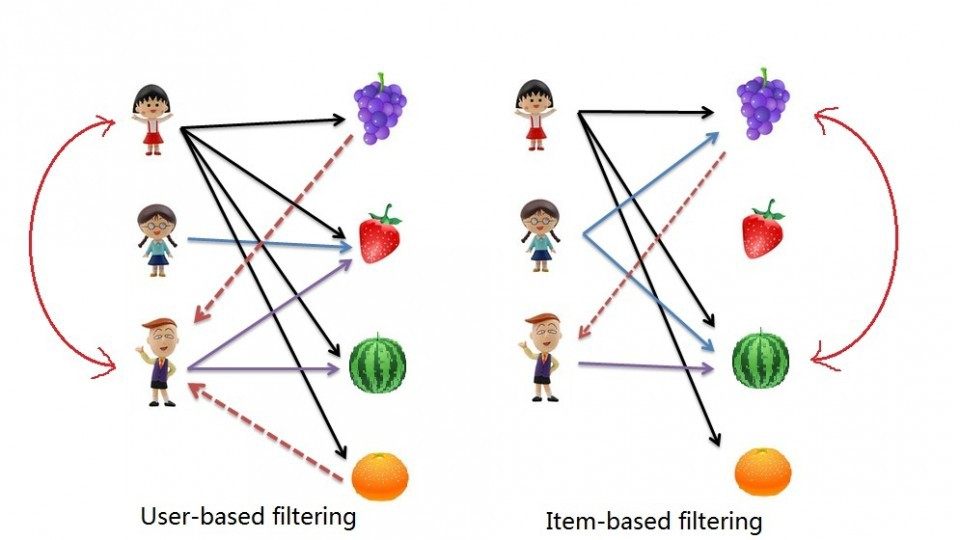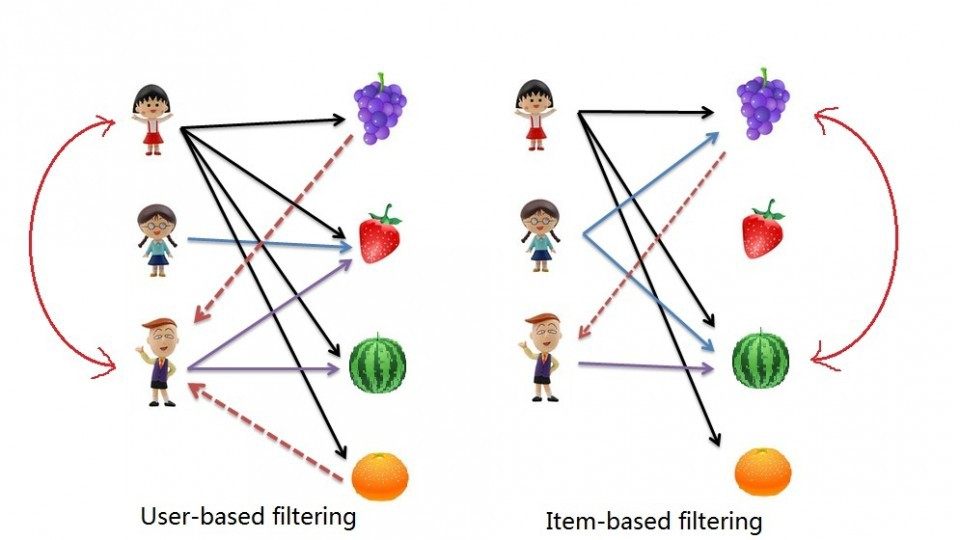

## Business Problem

Estimate using the item-based and user-based recommender methods for the user whose ID is given.

## Dataset and Story
MovieLens, a movie recommendation service, provided the dataset. It contains the rating scores for these movies along with the movies.

It contains 2,000,0263 ratings across 27,278 movies. This data was created by 138,493 users between 09 January 1995 and 31 March 2015. This data set was created on October 17, 2016. Users are randomly selected. It is known that all selected users voted for at least 20 movies.

#### Variables of the data set:

**movie.csv**

- movieId – Unique movie number. (UniqueID)<br>
- title – Movie name

**rating.csv**

- userid – Unique user number. (UniqueID)<br>
- movieId – Unique movie number. (UniqueID)<br>
- rating – The rating given to the movie by the user<br>
- timestamp – Evaluation date

### 1- Data Preparation

#### Import libraries and get the dataset

In [10]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.width', 100)


In [15]:
movie = pd.read_csv('../input/movielens-20m-dataset/movie.csv')
movie.head()
movie.shape

In [14]:
rating = pd.read_csv('../input/movielens-20m-dataset/rating.csv')
rating.head()
rating.shape
rating["userId"].nunique()

- Add the names and genres of the movies to the rating dataset using the movie movie set.
- Only the id's of the movies that the users voted in the rating have.
- We add the movie names and genre of the ids from the movie dataset.

In [4]:
df = movie.merge(rating, how="left", on="movieId")
df.head(50)
df.shape

- Calculate the total number of people who voted for each movie. Subtract the movies with less than 1000 votes from the data set.
- We calculate how many people voted in total for each movie.

In [5]:
comment_counts = pd.DataFrame(df["title"].value_counts())
comment_counts

- We keep the names of movies with less than 1000 votes in rare_movies.
- And we subtract from the dataset

In [6]:
rare_movies = comment_counts[comment_counts["title"] <= 1000].index
common_movies = df[~df["title"].isin(rare_movies)]
common_movies.shape

- In the index, there are userIDs, movie names in the columns and ratings as values.
- Create a pivot table for the dataframe.

In [7]:
user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")
user_movie_df.head()


- Let's functionalize all the above operations

In [1]:
def create_user_movie_df():
    import pandas as pd
    movie = pd.read_csv('../input/movielens-20m-dataset/movie.csv')
    rating = pd.read_csv('../input/movielens-20m-dataset/rating.csv')
    df = movie.merge(rating, how="left", on="movieId")
    comment_counts = pd.DataFrame(df["title"].value_counts())
    rare_movies = comment_counts[comment_counts["title"] <= 1000].index
    common_movies = df[~df["title"].isin(rare_movies)]
    user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")
    return user_movie_df

user_movie_df = create_user_movie_df()


### 2- Determining the Movies Watched by the User to Suggest

- Choose a random user id.

In [2]:
random_user = 108170

- Create a new dataframe named random_user_df consisting of observation units of the selected user.

In [3]:
random_user_df = user_movie_df[user_movie_df.index == random_user]
random_user_df.head()


- Assign the movies voted by the selected user to a list called movies_watched

In [4]:
movies_watched = random_user_df.columns[random_user_df.notna().any()].tolist()
movies_watched


### 3- Accessing Data and Ids of Other Users Watching the Same Movies

- Select the columns of the movies watched by the selected user from user_movie_df and create a new dataframe named movies_watched_df.

In [5]:
movies_watched_df = user_movie_df[movies_watched]
movies_watched_df.head()
movies_watched_df.shape


- Create a new dataframe named user_movie_count, which contains the information about how many movies each user has watched

In [6]:
user_movie_count = movies_watched_df.T.notnull().sum()
user_movie_count = user_movie_count.reset_index()
user_movie_count.columns = ["userId", "movie_count"]
user_movie_count.head(50)


- We consider those who watch 60 percent or more of the movies voted by the selected user as similar users.
- Create a list named users_same_movies from the ids of these users.

In [7]:
perc = len(movies_watched) * 60 / 100
users_same_movies = user_movie_count[user_movie_count["movie_count"] > perc]["userId"]
len(users_same_movies)


### 4- Determining the Users to be Suggested and Most Similar Users

- user_same_movies listesi içerisindeki seçili user ile benzerlik gösteren kullanıcıların id’lerinin bulunacağı şekilde movies_watched_df dataframe’ini filtreleyiniz.

In [8]:
final_df = movies_watched_df[movies_watched_df.index.isin(users_same_movies)]
final_df.head()
final_df.shape


- Create a new corr_df dataframe where users' correlations with each other will be found.

In [11]:
corr_df = final_df.T.corr().unstack().sort_values()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['user_id_1', 'user_id_2']
corr_df = corr_df.reset_index()
corr_df[corr_df["user_id_1"] == random_user]


- Create a new dataframe named top_users by filtering out the users with high correlation (over 0.65) with the selected user

In [12]:
top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >= 0.65)][["user_id_2", "corr"]].reset_index(drop=True)
top_users = top_users.sort_values(by='corr', ascending=False)
top_users.rename(columns={"user_id_2": "userId"}, inplace=True)
top_users.shape


- Merge the top_users dataframe with the rating dataset

In [16]:
top_users_ratings = top_users.merge(rating[["userId", "movieId", "rating"]], how='inner')
top_users_ratings = top_users_ratings[top_users_ratings["userId"] != random_user]
top_users_ratings["userId"].unique()
top_users_ratings.head()


### 5- Calculating Weighted Average Recommendation Score and Keeping Top 5 Movies

- Create a new variable named weighted_rating, which is the product of each user's corr and rating.

In [17]:
top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['rating']

- Create a new dataframe named recommendation_df containing the movie id and the average value of the weighted ratings of all users for each movie.

In [18]:
recommendation_df = top_users_ratings.groupby('movieId').agg({"weighted_rating": "mean"})
recommendation_df = recommendation_df.reset_index()
recommendation_df.head()


- Select movies with a weighted rating greater than 3.5 in recommendation_df and rank them by weighted rating.
- Save the first 5 observations as movies_to_be_recommend.

In [19]:
recommendation_df[recommendation_df["weighted_rating"] > 3.5]
movies_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 3.5].sort_values("weighted_rating", ascending=False)



- Bring the names of the 5 recommended films.

In [20]:
movies_to_be_recommend.merge(movie[["movieId", "title"]])["title"].head()

### 6- Item-Based Recommendation

- Make an item-based suggestion based on the name of the movie that the user last watched and gave the highest rating.

In [21]:
user = 108170

- read movie,rating datasets

In [22]:
movie = pd.read_csv('../input/movielens-20m-dataset/movie.csv')
rating = pd.read_csv('../input/movielens-20m-dataset/rating.csv')


- Get the id of the movie with the most recent score from the movies that the user to be suggested gives 5 points

In [23]:
movie_id = rating[(rating["userId"] == user) & (rating["rating"] == 5.0)].sort_values(by="timestamp", ascending=False)["movieId"][0:1].values[0]



- Filter the user_movie_df dataframe created in the User based recommendation section according to the selected movie id.

In [24]:
movie_df = user_movie_df[movie[movie["movieId"] == movie_id]["title"].values[0]]

- Using the filtered dataframe, find the correlation of the selected movie with the other movies and rank them.

In [25]:
user_movie_df.corrwith(movie_df).sort_values(ascending=False).head(10)

- Function that performs the last two steps

In [26]:
def item_based_recommender(movie_name, user_movie_df):
    movie = user_movie_df[movie_name]
    return user_movie_df.corrwith(movie).sort_values(ascending=False).head(10)


- Please give the first 5 movies as suggestions except the selected movie itself.

In [27]:
movies_from_item_based = item_based_recommender(movie[movie["movieId"] == movie_id]["title"].values[0], user_movie_df)
movies_from_item_based[1:6].index